<a href="https://colab.research.google.com/github/Ronnypetson/titanic/blob/master/MNIST_Maromba.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Experimentos do Produto Interno Maromba no MNIST

### Ambiente

In [1]:
import torch
import numpy as np
import torch.nn as nn
from torchvision.datasets import MNIST, FashionMNIST
from torchvision.transforms import ToTensor
from torch.optim import Adam

import pandas as pd
from sklearn.metrics import accuracy_score
# !pip3 install ipympl
# !pip3 install mpl_interactions
# %matplotlib widget

import matplotlib.pylab as plt
import plotly.express as px
# import mpl_interactions.ipyplot as iplt
import time
from IPython import display
from IPython.core.debugger import Pdb

device = "cuda:0" if torch.cuda.is_available() else "cpu"

# %matplotlib inline
# from google.colab import output
# output.enable_custom_widget_manager()

### Dataset

In [2]:
tr = ToTensor()

img_dim = 28

def _transform(x):
  x = x.resize((img_dim, img_dim))
  return (tr(x) * 2.0 - 1.0).reshape(-1)

bsize = 32

MNIST_train_data = MNIST(
    "MNIST_root/",
    download=True,
    train=True,
    transform=_transform,
)
train_data_loader = torch.utils.data.DataLoader(
    MNIST_train_data,
    batch_size=bsize,
    shuffle=True,
    num_workers=1,
)

MNIST_test_data = MNIST(
    "MNIST_root_test/",
    download=True,
    train=False,
    transform=_transform,
)
test_data_loader = torch.utils.data.DataLoader(
    MNIST_test_data,
    batch_size=bsize,
    shuffle=True,
    num_workers=1,
)

In [3]:
def _cat2d(rows, cols, d=32):
  """
  Index in the log-softmax scale.
  After sotmax (in the partition dimension)
  -inf --> 0
  1.0  --> 1
  """
  assert rows + cols <= d
  inf = 1.0
  idx = np.zeros((rows, cols, d)) - inf
  for row in range(rows):
    for col in range(cols):
      idx[row, col, row] = 1.0
      idx[row, col, rows + col] = 1.0
  idx = torch.from_numpy(idx)
  idx = idx.reshape(rows * cols, d)
  return idx

def cartesian_idx(rows, cols, d=2):
  idx = np.zeros((rows, cols, d))
  for row in range(rows):
    for col in range(cols):
      # idx[row, col, 0] = (1 + row) / rows
      # idx[row, col, 1] = (1 + col) / cols
      idx[row, col, 0] = 2.0 * ((row) / rows) - 1.0 ### (row + 1)
      idx[row, col, 1] = 2.0 * ((col) / cols) - 1.0 ### (col + 1)
  idx = torch.from_numpy(idx)
  idx = idx.reshape(rows * cols, d)
  return idx

### Kernels, similaridades e funções de índice

#### Kernels

In [4]:
def _soft_kernel(idxu, part_dim):
  """
  idxu: M x d_u x d_idx
  """
  m, d_u, d_idx = idxu.shape
  assert d_idx % part_dim == 0
  range = 20.0
  norm_idxu = range * idxu.reshape(m, d_u, -1, part_dim) - (range / 2.0)
  norm_idxu = torch.softmax(norm_idxu, dim=-1)
  dim_norm = (d_idx // part_dim) ** 0.5
  norm_idxu = norm_idxu.reshape(m, d_u, d_idx) / dim_norm
  return norm_idxu

def _cosine_kernel(idxu, *args, **kwargs):
  """
  idxu: M x d_u x d_idx
  """
  # TODO: compute min_idx, max_idx and normalize
  m, d_u, d_idx = idxu.shape
  min_idxu = torch.min(idxu, dim=1)[0].unsqueeze(1)
  max_idxu = torch.max(idxu, dim=1)[0].unsqueeze(1)
  eps = 1e-4
  idxu = (idxu - min_idxu) / (max_idxu - min_idxu + eps)
  norm_idxu = idxu / (torch.norm(idxu, dim=-1).unsqueeze(-1) + eps)
  # Reverse kernel trick for polynomial x^2
  idxu2 = norm_idxu.reshape(-1, d_idx, 1)
  idxu2 = torch.bmm(idxu2, idxu2.permute(0, 2, 1)).reshape(m, d_u, -1)
  # return norm_idxu
  return idxu2

#### Similaridades

In [5]:
def squared_cosine(idxu, idxv):
  """
  idxu: pre_shape x d_idx
  idxv: pre_shape x d_idx
  """
  assert idxu.shape == idxv.shape
  d_idx = idxu.shape[-1]
  sim = torch.bmm(
      idxu.reshape(-1, 1, d_idx),
      idxv.reshape(-1, d_idx, 1),
  )
  # sim = (torch.exp(sim) - 1.0) / (1.718)
  sim = sim ** 4.0
  return sim

def relu_cosine(idxu, idxv, bias=0.9):
  """
  idxu: pre_shape x d_idx
  idxv: pre_shape x d_idx
  """
  assert idxu.shape == idxv.shape
  d_idx = idxu.shape[-1]
  sim = nn.functional.relu(
      torch.bmm(
          idxu.reshape(-1, 1, d_idx),
          idxv.reshape(-1, d_idx, 1),
      )
      - bias
  )
  sim = sim.reshape(idxu.shape[:-1])
  return sim

#### Funções-valor

In [6]:
def vecsum(u, v):
  return u + v

def vecmean(u, v):
  return (u + v) / 2.0

def vecprod(u, v):
  """
  Element-wise product. NOT dot product.
  """
  return u * v

#### Dots

##### Utilities

In [7]:
class Pairwise:
  def __init__(self, f):
    """
    f: (pre_shape x d_val, pre_shape x d_val) -> pre_shape x d_val_out
    """
    self._f = f

  def __call__(self, u, v):
    """
    u: pre_shape_u x d_u x d_val
    v: pre_shape_v x d_v x d_val
    ans: pre_shape_u x pre_shape_v x d_u x d_v x d_val_out
    """
    ps_u, ps_v = u.shape[:-2], v.shape[:-2]
    pps_u, pps_v = np.prod(ps_u), np.prod(ps_v)
    d_u, d_val = u.shape[-2:]
    d_v, d_valv = v.shape[-2:]
    assert d_val == d_valv
    # u, v: pps_u x pps_v x d_u x d_v x d_val
    u = u.reshape(pps_u,     1, d_u,   1, d_val)
    v = v.reshape(    1, pps_v,   1, d_v, d_val)
    u = u.repeat(     1, pps_v,   1, d_v,     1)
    v = v.repeat( pps_u,     1, d_u,   1,     1)
    # fuv: ps_u x ps_v x d_u x d_v x d_val_out
    fuv = self._f(u, v)
    fuv = fuv.reshape(*ps_u, *ps_v, d_u, d_v, -1)
    return fuv

def __minmax_normalize(idxu):
  """
  idxu: pre_shape x d_idx
  """
  min_idxu = torch.min(idxu, dim=1)[0].unsqueeze(1)
  max_idxu = torch.max(idxu, dim=1)[0].unsqueeze(1)
  eps = 1e-6
  idxu = min_idxu + ((idxu - min_idxu) / (max_idxu - min_idxu + eps))
  return idxu

def minmax_normalize(idxu):
  """
  idxu: pre_shape x d_idx
  """
  min_idxu = torch.min(idxu, dim=1)[0].unsqueeze(1)
  max_idxu = torch.max(idxu, dim=1)[0].unsqueeze(1)
  eps = 1e-6
  idxu = 2.0 * ((idxu - min_idxu) / (max_idxu - min_idxu + eps)) - 1.0
  return idxu

def norm_normalize(u):
  """
  u: pre_shape x d_val
  """
  eps = 1e-6
  u = u / (u.norm(dim=-1).unsqueeze(-1) + eps)
  return u

def normalized(idxu):
  """
  idxu: pre_shape x d_idx
  """
  idxu = minmax_normalize(idxu)
  idxu = norm_normalize(idxu)
  return idxu

from functools import lru_cache

@lru_cache()
def get_eye(m, d_u, d_v, n, device="cpu"):
  eye = (
      torch.eye(max(d_u, d_v))
      [:d_u, :d_v]
      .unsqueeze(0)
      .unsqueeze(-1)
      .repeat(m, 1, 1, n)
      .to(device)
  )
  return eye

##### Dot products

In [8]:
def _sgbmd(u, v, idxu, idxv, sim=None, f=None, normalize=True) -> torch.Tensor:
  """
  "Slow General Batch Maromba Dot"
  Slower, more general, implementation for the "batch maromba dot" operation.
  u: M x d_u x d_val
  v: N x d_v x d_val
  idxu: M x d_u x d_idx
  idxv: N x d_v x d_idx
  sim: index similarity function
  f: value function
  """
  m, d_u, d_idx  = idxu.shape
  n, d_v, d_idxv = idxv.shape
  d_val = u.shape[-1]
  assert d_idx == d_idxv
  assert d_val == v.shape[-1]
  assert (m, d_u) == u.shape[:2]
  assert (n, d_v) == v.shape[:2]
  sim = Pairwise(sim)
  f = Pairwise(f)
  ###
  idxu = normalized(idxu)
  idxv = normalized(idxv)
  ###
  # sims: (M * N) x 1 x (d_u * d_v)
  # vals: (M * N) x (d_u * d_v) x d_val
  sims = sim(idxu, idxv).reshape(m * n, 1, d_u * d_v) ###
  norm = 1.0
  if normalize:
    # norm: (M * N) x 1
    norm = sims.sum(dim=-1)
  vals = f(u, v)
  vals = vals.reshape(m * n, d_u * d_v, d_val)
  # dot: M x N x d_val
  dot = torch.bmm(sims, vals).squeeze(1)
  eps = 1e-8
  dot = (dot / (norm + eps)).reshape(m, n, d_val)
  return dot

def _rdot(u, v, *args):
  """
  "Regular Dot product"
  u: M x d_u x d_val
  v: N x d_v x d_val
  """
  m, d_u, d_val = u.shape
  n, d_v, _d_val = v.shape
  if d_u != d_v:
    return _nsbmd(u, v, *args)
  assert _d_val == d_val
  dot = (
      u.permute(0, 2, 1).reshape(-1, d_u)
      @ v.permute(1, 0, 2).reshape(d_v, -1)
  ).reshape(m, d_val, n, d_val).permute(0, 2, 1, 3)
  dot = torch.diagonal(dot, dim1=2, dim2=3)
  return dot

def _nsbmd(u, v, idxu, idxv, bias=0.5) -> torch.Tensor:
  """
  "Non-linear Similarity Batch Maromba Dot"
  u: M x d_u x d_val
  v: N x d_v x d_val
  idxu: M x d_u x d_idx
  idxv: N x d_v x d_idx
  """
  m, d_u, d_idx  = idxu.shape
  n, d_v, d_idxv = idxv.shape
  d_val = u.shape[-1]
  assert d_idx == d_idxv
  assert d_val == v.shape[-1]
  assert (m, d_u) == u.shape[:2]
  assert (n, d_v) == v.shape[:2]
  # Pdb().set_trace()
  idxu = normalized(idxu)
  idxv = normalized(idxv)
  # idxuv: M x d_u x d_v x N
  # normalizer: M x N x 1
  idxuv = idxu.reshape(m * d_u, d_idx) @ idxv.reshape(n * d_v, d_idx).T
  idxuv = idxuv.reshape(m, d_u, n, d_v).permute(0, 1, 3, 2)
  # idxuv = idxuv ** 6.0
  # idxuv = nn.functional.relu(idxuv - bias) ###
  mag = 2.0 # 10.0 # 200.0
  idxuv = nn.functional.softmax(mag * idxuv - (mag / 2.0), dim=2)
  # idxuv = nn.functional.gumbel_softmax(
  #     6.0 * idxuv - 3.0, dim=2, hard=False, tau=0.2
  # )
  # idxuv = get_eye(m, d_u, d_v, n, idxuv.device)
  # idxuv = idxuv / (idxuv.sum(dim=2).unsqueeze(2) + 1e-6)
  # Pdb().set_trace()
  ###
  # normalizer = idxuv.reshape(m, d_u * d_v, n).sum(dim=1).reshape(m, n, 1)
  ###
  # normalizer = 1.0 - 1e-6
  # uidxuv: (M x d_val x d_v x N) -> (N x d_v x d_val x M)
  uidxuv = (
      torch.bmm(
        u.permute(0, 2, 1),
        idxuv.reshape(m, d_u, d_v * n)
      )
      .reshape(m, d_val, d_v, n)
      .permute(3, 2, 1, 0)
  )
  # uidxuvv: N x M x d_val x d_val
  uidxuvv = (
      torch.bmm(
          uidxuv.permute(0, 3, 2, 1).reshape(n * m, d_val, d_v),
          v.unsqueeze(1).repeat(1, m, 1, 1).reshape(n * m, d_v, d_val)
      )
      .reshape(n, m, d_val, d_val)
  )
  # dot: M x N x d_val
  dot = torch.diagonal(uidxuvv, dim1=2, dim2=3)
  dot = dot.permute(1, 0, 2)
  # dot = dot / (normalizer + 1e-6)
  return dot

def _gbmd(u, v, idxu, idxv, kernel=None, idx_part=None) -> torch.Tensor:
  """
  "General Batch Maromba Dot"
  Shorter implementation for the "batch maromba dot" operation.
  u: M x d_u
  v: N x d_v
  idxu: M x d_u x d_idx
  idxv: N x d_v x d_idx
  """
  m, d_u = u.shape
  n, d_v = v.shape
  d_idx = idxu.shape[-1]
  assert (m, d_u, d_idx) == idxu.shape
  assert (n, d_v, d_idx) == idxv.shape
  if kernel:
    idxu = kernel(idxu, idx_part)
    idxv = kernel(idxv, idx_part)
  # uidxu: M x d_idx
  # vidxv: N x d_idx
  uidxu = torch.bmm(u.reshape(m, 1, d_u), idxu).squeeze(1)
  vidxv = torch.bmm(v.reshape(n, 1, d_v), idxv).squeeze(1)
  dot = uidxu @ vidxv.T
  ### Under experimentation
  normalizer = idxu.sum(dim=1) @ idxv.sum(dim=1).T
  dot = dot / (normalizer + 1e-8) ###
  ###
  return dot

#### Índices

In [9]:
def _fast_kernel_idx_sum(idxu, idxv, k, idx_part):
  """
  k: callable: A x B x C -> A x B x C
  idxu: M x d_u x d_idx
  idxv: N x d_v x d_idx
  """
  ### idxu MUST be the input mini-batch
  batch_m = 1 # idxu.shape[0]
  # idxu = idxu.mean(dim=0).unsqueeze(0)
  ###
  m, d_u, d_idx = idxu.shape
  n, d_v, _ = idxv.shape
  assert d_idx == idxv.shape[-1]
  # kidxu: M x d_u x d_idx
  # kidxv: N x d_v x d_idx
  kidxu = k(idxu, idx_part)
  kidxv = k(idxv, idx_part)
  d_idx_k = kidxu.shape[-1]
  assert kidxu.shape[:-1] == idxu.shape[:-1]
  assert kidxv.shape[:-1] == idxv.shape[:-1]
  # kiTi: (M * d_idx) x d_idx(k)
  # kjTj: (N * d_idx) x d_idx(k)
  iTki = torch.bmm(idxu.permute(0, 2, 1), kidxu).reshape(m * d_idx, d_idx_k)
  jTkj = torch.bmm(idxv.permute(0, 2, 1), kidxv).reshape(n * d_idx, d_idx_k)
  ski = kidxu.sum(dim=1)
  skj = kidxv.sum(dim=1)
  norm = (ski @ skj.T).unsqueeze(-1)
  # sidx: (M * d_idx) x N + (N * d_idx) x M
  sidx = (
      (iTki @ skj.T).reshape(m, d_idx, n).permute(0, 2, 1)
      + (jTkj @ ski.T).reshape(n, d_idx, m).permute(2, 0, 1)
  )
  sidx = sidx / norm
  sidx = sidx.repeat(batch_m, 1, 1)
  return sidx

def _fast_kernel_idx(idxu, idxv, k, _idx_part):
  """
  k: callable: A x B x C -> A x B x C
  idxu: M x d_u x d_idx
  idxv: N x d_v x d_idx
  """
  ### idxu MUST be the input mini-batch
  batch_m = 1 # idxu.shape[0]
  # idxu = idxu.mean(dim=0).unsqueeze(0)
  ###
  m, d_u, d_idx = idxu.shape
  n, d_v, _ = idxv.shape
  assert d_idx == idxv.shape[-1]
  # kidxu: M x d_u x d_idx
  # kidxv: N x d_v x d_idx
  kidxu = k(idxu, _idx_part)
  kidxv = k(idxv, _idx_part)
  assert kidxu.shape == idxu.shape
  assert kidxv.shape == idxv.shape
  # kiTi: (M * d_idx) x d_idx(k)
  # kjTj: (N * d_idx) x d_idx(k)
  iTki = torch.bmm(idxu.permute(0, 2, 1), kidxu).reshape(m * d_idx, d_idx)
  jTkj = torch.bmm(idxv.permute(0, 2, 1), kidxv).reshape(n * d_idx, d_idx)
  # iTki_kjTj: M x N x d_idx x d_idx
  iTki_kjTj = (iTki @ jTkj.T).reshape(m, d_idx, n, d_idx).permute(0, 2, 1, 3)
  diag = torch.diagonal(iTki_kjTj, dim1=2, dim2=3)
  ###
  ski = kidxu.sum(dim=1)
  skj = kidxv.sum(dim=1)
  norm = (ski @ skj.T).unsqueeze(-1)
  diag = diag / norm
  ###
  diag = diag.repeat(batch_m, 1, 1)
  return diag

def _kernel_idx(idxu, idxv, k, _idx_part):
  """
  k: callable: A x B x C -> A x B x C
  idxu: M x d_u x d_idx
  idxv: N x d_v x d_idx
  """
  m, d_u, d_idx = idxu.shape
  n, d_v, _ = idxv.shape
  assert d_idx == idxv.shape[-1]
  # kidxu: M x d_u x d_idx
  # kidxv: N x d_v x d_idx
  kidxu = k(idxu, _idx_part)
  kidxv = k(idxv, _idx_part)
  assert kidxu.shape == idxu.shape
  assert kidxv.shape == idxv.shape
  # ski: (M * N) x d_idx
  # skj: (M * N) x d_idx
  # norm: M x N x 1
  ski = kidxu.sum(dim=1)
  skj = kidxv.sum(dim=1)
  norm = (ski @ skj.T).unsqueeze(-1)
  ski = ski.unsqueeze(1).repeat(1, n, 1).reshape(m * n, d_idx, 1)
  skj = skj.unsqueeze(1).repeat(m, 1, 1).reshape(m * n, d_idx, 1)
  # idxu, kidxu: (M * d_u) x d_idx x 1
  # idxv, kidxv: (N * d_v) x d_idx x 1
  idxu = idxu.reshape(m * d_u, d_idx, 1)
  idxv = idxv.reshape(n * d_v, d_idx, 1)
  kidxu = kidxu.reshape(m * d_u, d_idx, 1)
  kidxv = kidxv.reshape(n * d_v, d_idx, 1)
  # sikiT: M x d_idx x d_idx
  # sjkjT: N x d_idx x d_idx
  sikiT = torch.bmm(idxu, kidxu.permute(0, 2, 1))
  sikiT = sikiT.reshape(m, d_u, d_idx, d_idx).sum(dim=1)
  sjkjT = torch.bmm(idxv, kidxv.permute(0, 2, 1))
  sjkjT = sjkjT.reshape(n, d_v, d_idx, d_idx).sum(dim=1)
  del kidxu
  del kidxv
  del idxu
  del idxv
  # sikiT: (M * N) x d_idx x d_idx
  # sjkjT: (M * N) x d_idx x d_idx
  sikiT = sikiT.unsqueeze(1).repeat(1, n, 1, 1).reshape(m * n, d_idx, d_idx)
  sjkjT = sjkjT.unsqueeze(0).repeat(m, 1, 1, 1).reshape(m * n, d_idx, d_idx)
  # diag_sikiT_skjjT: (M * N) x d_idx
  # skjjT = sjkjT.permute(0, 2, 1)
  # diag_sikiT_skjjT = torch.diagonal(torch.bmm(sikiT, skjjT), dim1=1, dim2=2)
  # diag_sikiT_skjjT = diag_sikiT_skjjT.unsqueeze(-1)
  xor_idx = torch.bmm(sikiT, skj) + torch.bmm(sjkjT, ski)
  # xor_idx = torch.bmm(sikiT, skj) + torch.bmm(sjkjT, ski) - diag_sikiT_skjjT
  # xor_idx = diag_sikiT_skjjT
  xor_idx = xor_idx.reshape(m, n, d_idx)
  xor_idx = xor_idx / norm
  return xor_idx

### Classe Tensor Maromba

In [10]:
class MTensor:
  def __init__(
      self,
      values: torch.Tensor,
      indices: torch.Tensor,
      indexer: nn.Module=nn.Identity(),
    ):
    assert values.shape == indices.shape[:-1]
    self.data = values
    self.idx = indices
    self.idx_dim = indices.shape[-1]
    self.indexer = indexer
    self._idx_part = img_dim
    self._eps = 1e-6

  def __getitem__(self, idx):
    return MTensor(self.data[idx], self.idx[idx], self.indexer)

  def __setitem__(self, idx, value):
    self.data[idx] = value.data
    self.idx[idx] = value.idx

  def __delitem__(self, idx):
    del self.data[idx]
    del self.idx[idx]

  def __len__(self):
    return len(self.data)

  @staticmethod
  def cat(mts, dim=0):
    values = [mt.data for mt in mts]
    indices = [mt.idx for mt in mts]
    values = torch.cat(values, dim=dim)
    indices = torch.cat(indices, dim=dim)
    mt = MTensor(values, indices)
    return mt

  @staticmethod
  def unsqueeze(mt, dim=0):
    assert dim != -1
    assert dim < len(mt.idx.shape) - 1
    mt.data = mt.data.unsqueeze(dim)
    mt.idx = mt.idx.unsqueeze(dim)
    return mt

  @staticmethod
  def squeeze(mt, dim=0):
    assert dim != -1
    assert dim < len(mt.idx.shape) - 1
    mt.data = mt.data.squeeze(dim)
    mt.idx = mt.idx.squeeze(dim)
    return mt

  @staticmethod
  def clone(mt):
    return MTensor(mt.data, mt.idx, mt.indexer)

  @staticmethod
  def reshape(mt, shape):
    idx_shape = shape + (mt.idx_dim,)
    nmt = MTensor(
        mt.data.reshape(shape),
        mt.idx.reshape(idx_shape),
        mt.indexer
    )
    return nmt

  @staticmethod
  def permute(mt, perm):
    idx_perm = perm + (-1,)
    nmt = MTensor(
        mt.data.permute(*perm),
        mt.idx.permute(*idx_perm),
        mt.indexer
    )
    return nmt

  def __matmul__(self, b):
    """
    Useful for computing m-product between a batch of inputs (N x ...) and a
    parameter matrix (m x n).

    self.data: pre_shape(self) x in_dim(self)
    self.data.idx: pre_shape(self) x in_dim(self) x d_idx
    b.data: pre_shape(b) x in_dim(b)
    b.idx: pre_shape(b) x in_dim(b) x d_idx

    Returns "mdot"
    mdot.data: pre_shape(self) x pre_shape(b)
    mdot.idx: pre_shape(self) x pre_shape(b) x d_idx
    """
    apre = self.data.shape[:-1]
    bpre = b.data.shape[:-1]
    d_idx = self.idx.shape[-1]
    assert d_idx == b.idx.shape[-1]
    aidx = self.idx.reshape(*((-1,) + self.idx.shape[-2:]))
    bidx = b.idx.reshape(*((-1,) + b.idx.shape[-2:]))
    kernel = _soft_kernel
    # kernel = _cosine_kernel
    # mdot = _gbmd(
    #     self.data.reshape(-1, self.data.shape[-1]),
    #     b.data.reshape(-1, b.data.shape[-1]),
    #     aidx,
    #     bidx,
    #     kernel=kernel,
    #     idx_part=self._idx_part,
    # )
    # mdot = _sgbmd(
    #     self.data.reshape(-1, self.data.shape[-1], 1),
    #     b.data.reshape(-1, b.data.shape[-1], 1),
    #     aidx,
    #     bidx,
    #     sim=relu_cosine,
    #     # sim=squared_cosine,
    #     f=vecprod,
    # )
    ###
    mdot = _nsbmd(
        self.data.reshape(-1, self.data.shape[-1], 1),
        b.data.reshape(-1, b.data.shape[-1], 1),
        aidx,
        bidx,
    )
    ###
    # mdot = _rdot(
    #     self.data.reshape(-1, self.data.shape[-1], 1),
    #     b.data.reshape(-1, b.data.shape[-1], 1),
    #     aidx,
    #     bidx,
    # )
    ###
    mdot = mdot.reshape(apre + bpre)
    # New indices
    # _kernel_idx # _fast_kernel_idx # _fast_kernel_idx_sum
    # midx = _fast_kernel_idx_sum(
    #     aidx,
    #     bidx,
    #     kernel,
    #     self._idx_part,
    # )
    # midx = _sgbmd(
    #     aidx,
    #     bidx,
    #     aidx,
    #     bidx,
    #     sim=relu_cosine,
    #     # sim=squared_cosine,
    #     # f=vecsum,
    #     f=vecmean,
    # )
    ###
    onesa = torch.ones(self.idx.shape).to(self.idx.device)
    onesb = torch.ones(b.idx.shape).to(b.idx.device)
    # midx = norm_normalize(
    #     norm_normalize(_nsbmd(aidx, onesb, aidx, bidx))
    #     + norm_normalize(_nsbmd(onesa, bidx, aidx, bidx))
    # )
    # midx = norm_normalize(_nsbmd(aidx, bidx, aidx, bidx))
    midx = (
        _nsbmd(aidx, onesb, aidx, bidx)
        + _nsbmd(onesa, bidx, aidx, bidx)
    ) / 2.0
    # Pdb().set_trace()
    ###
    # midx = norm_normalize(
    #     norm_normalize(_rdot(aidx, onesb, aidx, bidx))
    #     + norm_normalize(_rdot(onesa, bidx, aidx, bidx))
    # )
    ###
    new_shape = apre + bpre + (d_idx,)
    midx = midx.reshape(new_shape)
    #
    mdot = MTensor(mdot, midx, self.indexer)
    return mdot

  def __mul__(self, b):
    """
    self: N x out_a x in_a (x d_idx)
    b:    N x out_b x in_b (x d_idx)
    """
    n, out_a, in_a = self.data.shape
    assert b.data.shape[0] == n
    _, out_b, in_b = b.data.shape
    d_idx = self.idx.shape[-1]
    assert b.idx.shape[-1] == d_idx
    ### Solução provisória. Calcular o índice com paralelismo ainda não é possível.
    mdots = [MTensor.unsqueeze(self[idx] @ b[idx], dim=0) for idx in range(n)]
    mdots = MTensor.cat(mdots, dim=0)
    return mdots

### Classe do Módulo Treinável

#### Sampling functions

In [11]:
def idx2d(
    channels: int,
    rows: int,
    cols: int,
    w: int,
    h: int,
    stride: int=2,
    dilation: int=1,
    device="cpu"
  ):
  idx = []
  dilh = 1 + dilation * (h - 1)
  dilw = 1 + dilation * (w - 1)
  for row in range(0, rows - (dilh - 1), stride):
    for col in range(0, cols - (dilw - 1), stride):
      for ch in range(channels):
        for drow in range(0, dilh, dilation):
          for dcol in range(0, dilw, dilation):
            idx.append(
                cols * rows * ch
                + cols * (row + drow)
                + (col + dcol)
            )
  idx = torch.tensor(idx).long().to(device)
  return idx

def unsort(idxs):
  ridxs = [0 for _ in idxs]
  for i, idx in enumerate(idxs):
    ridxs[idx] = i
  ridxs = torch.tensor(ridxs).long().to(idxs.device)
  return ridxs

def get_perms(tmp_idx):
  idxs, _idxs = [], []
  for dim in range(tmp_idx.shape[-1]):
    ordering = torch.argsort(tmp_idx[:, dim], stable=True)
    idxs.append(ordering.cpu().detach())
    _idxs.append(unsort(ordering).cpu().detach())
  return idxs, _idxs

def resort(k, src, tgt):
  assert src == 0 or tgt == 0
  global idxs, _idxs
  if tgt == 0:
    return idxs[src][k]
  return _idxs[tgt][k]

def hoods(dims, k0, w, _min=0, _max=None):
  assert len(dims) == len(w), f"{len(dims)} != {len(w)}"
  if len(dims) == 0:
    return [k0] # [k0.item()]
  _hoods = []
  global idxs, _idxs
  _k0d = resort(k0, 0, dims[-1]) #, idxs, _idxs)
  for _w in range(-(w[-1] // 2), (w[-1] // 2) + (w[-1] % 2)):
    # k0d = min(_max, max(_min, _k0d + _w))
    k0d = torch.clip(_k0d + _w, min=_min, max=_max)
    _hoods += hoods(
        dims[:-1],
        resort(
            k0d,
            dims[-1], 0,
            # idxs, _idxs
        ),
        w[:-1],
        # idxs, _idxs,
        _min, _max
    )
  return _hoods

idxs, _idxs = None, None

from sklearn.neighbors import NearestNeighbors

def idxhood(xidx, ws, stride):
  xidx = xidx.reshape(-1, 2).cpu().detach().numpy()
  # set desired number of neighbors
  nneigh = int(np.prod(ws))
  neigh = NearestNeighbors(n_neighbors=nneigh)
  neigh.fit(xidx)
  # select indices of k nearest neighbors of the vectors in the input list
  all_hoods = neigh.kneighbors(xidx, return_distance=False).reshape(-1)
  all_hoods = torch.from_numpy(all_hoods).long()
  return all_hoods

def _idxhood(xidx, ws, stride):
  """
  xidx: in_dim x idx_dim
  """
  dims = tuple(range(xidx.shape[-1]))
  global idxs, _idxs
  idxs, _idxs = get_perms(xidx)
  pivots = torch.tensor([piv for piv in range(0, len(xidx), stride)]).long()
  all_hoods = hoods(dims, pivots, ws, 0, len(xidx) - 1)
  # all_hoods = torch.tensor(all_hoods).long().T.reshape(-1)
  all_hoods = torch.cat(all_hoods, dim=0).reshape(len(all_hoods), -1).T
  all_hoods = all_hoods.reshape(-1)
  # Pdb().set_trace()
  return all_hoods

#### MModule

In [12]:
class MModule(nn.Module):
  def __init__(
      self, n_params=600, idx_dim=32, samples=32, sets=64, device="cpu",
      probe_dim=None,
      ):
    super().__init__()
    self.idx_dim = idx_dim
    self.samples = samples
    self.sets = sets
    self.device = device
    self.n_params = n_params
    ### TODO: checar inicialização de W
    # self.W = nn.Parameter(torch.randn((1, n_params), device=device))
    self.W = nn.Parameter(
        2.0 * torch.rand((1, n_params), device=device) - 1.0
    )
    self.W_idx = nn.Parameter(
        2.0 * torch.rand((1, n_params, idx_dim), device=device) - 1.0
    )
    # self.W_idx = _W_idx
    self.MW = MTensor(self.W, self.W_idx)
    ###
    if probe_dim:
      self.probe = nn.Linear(probe_dim, 10).to(device) # 288, 400, 512
    ###
    # self.activation = nn.ReLU()
    self.activation = nn.ELU()

  def _W_step(
      self,
      x: MTensor,
      W: MTensor,
      sets,
      samples,
      random=True,
      conv=False,
      filter_size=4,
      activation=True,
      regular_dot=False):
    """
    x.data: N x in_dim
    x.idx: N x in_dim x idx_dim
    """
    n, in_dim, idx_dim = x.idx.shape
    assert x.data.shape == (n, in_dim)
    # Put 1 into x
    if not conv:
      filter_size = in_dim
    assert (in_dim % filter_size) == 0
    num_windows = (in_dim // filter_size)
    # one = MTensor(
    #     torch.ones((n * num_windows), 1).to(self.device),
    #     torch.ones((n * num_windows), 1, idx_dim).to(self.device),
    # )
    x = MTensor.reshape(x, (n * num_windows, filter_size))
    # Sample W
    if conv:
      ### filter_size + 1
      assert (sets * samples) % (filter_size) == 0
      numw_windows = (sets * samples) // (filter_size)
      sets, samples = numw_windows, (filter_size)
    W_sets = MTensor.reshape(W, (sets, samples))
    ## mdot: N x sets
    # mdot: (N * num_windows) x numw_windows
    mdot = x @ W_sets
    if activation:
      mdot.data = self.activation(mdot.data)
    # mdot: N x num_windows x numw_windows
    if conv:
      ### Várias "imagens" coladas em um sentido
      mdot = MTensor.reshape(mdot, (n, num_windows, numw_windows))
    return mdot

  def forward(self, x: MTensor):
    """
    x.data: N x in_dim
    x.idx: N x in_dim x idx_dim
    """
    n_sets, n_samples = len(self.sets), len(self.samples)
    assert n_sets == n_samples
    assert n_sets > 0
    ### Under experimentation
    channels = 1
    img_h, img_w = img_dim, img_dim
    filter_whs = [(3, 3), (3, 3)]
    strides = [2, 1]
    filter_w, filter_h = filter_whs[0]
    stride = strides[0]
    filter_area = filter_w * filter_h
    filter_volume = channels * filter_area
    self.all_pools = [x[:4]]
    idx = idx2d(
        channels,
        img_h, img_w,
        filter_w, filter_h,
        stride=stride,
        device=self.device
    )
    x = x[:, idx]
    ###
    pool = x
    wl, wr = 0, self.sets[0] * self.samples[0]
    for step in range(n_sets):
      activate = (step < n_sets - 1)
      conv = activate
      if conv:
        pool = self._W_step(
            pool,
            self.MW[:, wl: wr],
            self.sets[step],
            self.samples[step],
            random=False,
            conv=conv,
            filter_size=filter_volume,
            activation=activate,
        )
      else:
        pool.data = self.probe(pool.data)
      ###
      nxt_conv = (step + 1 < n_sets - 1)
      ###
      if conv:
        # pool: N x num_windows x numw_windows
        self.all_pools.append(pool[:4])
        n, img_area, channels = pool.data.shape
        filter_volume = channels * filter_area
        pool = MTensor.permute(pool, (0, 2, 1))
        pool = MTensor.reshape(pool, (n, -1))
        # assert img_dim % stride == 0
        img_h = (img_h - filter_h + stride) // stride
        img_w = (img_w - filter_w + stride) // stride
        assert img_h * img_w == img_area
        # cols = pool.data.shape[1] // rows
        nxt_conv_step = (step + 1) % len(strides)
        filter_w, filter_h = filter_whs[nxt_conv_step]
        stride = strides[nxt_conv_step]
        filter_area = filter_w * filter_h
        filter_volume = channels * filter_area
        if nxt_conv:
          idx = idx2d(
              channels,
              img_h, img_w,
              filter_w, filter_h,
              stride=stride,
              device=self.device
          )
          pool = pool[:, idx]
      ###
      nxt_step = (step + 1) % n_sets
      next_wr = wr + self.sets[nxt_step] * self.samples[nxt_step]
      wl, wr = wr, next_wr
    return pool

#### MModule II

In [13]:
class MModule2(nn.Module):
  def __init__(
      self, n_params=600, idx_dim=32, samples=32, sets=64, device="cpu",
      probe_dim=None,
      ):
    super().__init__()
    self.idx_dim = idx_dim
    self.samples = samples
    self.sets = sets
    self.device = device
    self.n_params = n_params
    ### TODO: checar inicialização de W
    # self.W = nn.Parameter(torch.randn((1, n_params), device=device))
    self.W = nn.Parameter(
        2.0 * torch.rand((1, n_params), device=device) - 1.0
    )
    self.W_idx = nn.Parameter(
        2.0 * torch.rand((1, n_params, idx_dim), device=device) - 1.0
    )
    # self.W_idx = _W_idx
    self.MW = MTensor(self.W, self.W_idx)
    ###
    if probe_dim:
      self.probe = nn.Linear(probe_dim, 10).to(device) # 288, 400, 512
    ###
    # self.activation = nn.ReLU()
    self.activation = nn.ELU()
    self._prev_idx = None

  def forward(self, x: MTensor):
    """
    x.data: N x in_dim
    x.idx: N x in_dim x idx_dim
    """
    n_sets, n_samples = len(self.sets), len(self.samples)
    assert n_sets == n_samples
    assert n_sets > 0
    ### Under experimentation
    n = x.data.shape[0]
    filter_whs = [(3, 3, 1), (3, 3, 2), (3, 3, 2)]
    strides = [1, 1, 1]
    stride = strides[0]
    filter_volume = np.prod(filter_whs[0])
    self.all_pools = [x[:4]]
    idxx = idxhood(x.idx[0], filter_whs[0], strides[0]) ### FIX
    # pool: N x (num_windows * window_volume)
    pool = x[:, idxx]
    ###
    wl, wr = 0, self.sets[0] * self.samples[0]
    # idxw = idxhood(
    #     mw.idx,
    #     filter_whs[0],
    #     strides[0]
    # ) ### FIX
    # mw = mw[:, idxw]
    for step in range(n_sets):
      mw = MTensor.reshape(
          self.MW[0, wl: wr],
          (self.sets[step], self.samples[step])
      )
      activate = (step < n_sets - 1)
      conv = activate
      if conv:
        # pool: (N * num_windows) x  sets
        # Pdb().set_trace()
        pool = MTensor.reshape(pool, (-1, filter_volume)) @ mw
        pool = MTensor.reshape(pool, (n, -1, self.sets[step]))
      else:
        pool.data = self.probe(pool.data)
      ###
      nxt_conv = (step + 1 < n_sets - 1)
      ###
      if conv:
        # pool: N x num_windows x numw_windows
        self.all_pools.append(pool[:4])
        n, img_area, channels = pool.data.shape
        # pool = MTensor.permute(pool, (0, 2, 1))
        pool = MTensor.reshape(pool, (n, -1))
        nxt_conv_step = (step + 1) % len(strides)
        stride = strides[nxt_conv_step]
        filter_volume = np.prod(filter_whs[nxt_conv_step])
        if nxt_conv:
          idxx = idxhood(
              pool.idx[0],
              filter_whs[nxt_conv_step],
              strides[nxt_conv_step]
          ) ### FIX
          pool = pool[:, idxx]
      ###
      nxt_step = (step + 1) % n_sets
      next_wr = wr + self.sets[nxt_step] * self.samples[nxt_step]
      wl, wr = wr, next_wr
    # Pdb().set_trace()
    # if self._prev_idx is not None:
    #   print((self._prev_idx - self.all_pools[-1][0].idx).mean())
    # self._prev_idx = self.all_pools[-1][0].idx
    return pool

### Função de Custo

In [14]:
from sklearn.metrics import accuracy_score

def _check_shapes(y_true, y_pred, true_index, pred_index):
  n, d_out = y_true.shape
  assert y_true.shape[0] == y_pred.shape[0]
  assert true_index.shape[0] == pred_index.shape[0]
  assert true_index.shape[-1] == pred_index.shape[-1]

def _maromba_loss(y_true, y_pred, true_index, pred_index):
  """
  y_true: N x d_out(true)
  y_pred: N x d_out(pred)
  true_index: N x d_out(true) x d_index
  pred_index: N x d_out(pred) x d_index
  """
  _check_shapes(y_true, y_pred, true_index, pred_index)
  # index_match: N x d_out(pred) x d_out(true)
  ###
  pred_index = MTensor._soft_kernel(pred_index, img_dim)
  # pred_index = MTensor._cosine_kernel(pred_index)
  ###
  index_match = torch.bmm(pred_index, true_index.permute(0, 2, 1))
  ### Under experimentation
  # index_match = nn.functional.softmax(index_match, dim=-1)
  ###
  # y_true_match: N x 1 x d_out(pred)
  # y_pred_match: N x 1 x d_out(true)
  y_pred_match = torch.bmm(y_pred.unsqueeze(1), index_match)
  y_true_match = torch.bmm(y_true.unsqueeze(1), index_match.permute(0, 2, 1))
  # huber = nn.HuberLoss()
  # match_loss_lr = huber(y_pred, y_true_match.squeeze(1))
  # match_loss_rl = huber(y_true, y_pred_match.squeeze(1))
  # loss = match_loss_lr + match_loss_rl
  ce = nn.CrossEntropyLoss() # nn.NLLLoss() #
  loss_lr = ce(y_pred_match.squeeze(1), torch.argmax(y_true, dim=-1))
  # loss_rl = ce(y_true_match.squeeze(1), torch.argmax(y_pred, dim=-1))
  loss_rl = ce(y_pred, torch.argmax(y_true_match.squeeze(1), dim=-1))
  loss = loss_lr + loss_rl
  return loss

def _pool2category(y_true, y_pred, true_index, pred_index):
  _check_shapes(y_true, y_pred, true_index, pred_index)
  # index_match: N x d_out(pred) x d_out(true)
  index_match = torch.bmm(pred_index, true_index.permute(0, 2, 1))
  y_pred_match = torch.bmm(y_pred.unsqueeze(1), index_match)
  y_pred_match = torch.argmax(y_pred_match.squeeze(1), dim=-1).tolist()
  return y_pred_match

def _maromba_accuracy(y_true, y_pred, true_index, pred_index):
  ###
  # pred_index = MTensor._cosine_kernel(pred_index)
  pred_index = MTensor._soft_kernel(pred_index, img_dim)
  ###
  y_pred_match = _pool2category(y_true, y_pred, true_index, pred_index)
  y_true = torch.argmax(y_true, dim=-1).tolist()
  acc = accuracy_score(y_true, y_pred_match)
  return acc

def maromba_accuracy(y_true, y_pred):
  return _maromba_accuracy(y_true.data, y_pred.data, y_true.idx, y_pred.idx)

def maromba_loss(y_true, y_pred):
  return _maromba_loss(y_true.data, y_pred.data, y_true.idx, y_pred.idx)

def regular_accuracy(y_true, y_pred):
  y_true = torch.argmax(y_true.data, dim=-1).tolist()
  y_pred = torch.argmax(y_pred.data, dim=-1).tolist()
  acc = accuracy_score(y_true, y_pred)
  return acc

def regular_loss(y_true, y_pred):
  y_true = y_true.data
  y_pred = 10.0 * y_pred.data
  ce = nn.CrossEntropyLoss()
  loss = ce(y_pred, torch.argmax(y_true, dim=-1))
  return loss

maromba_loss = regular_loss
maromba_accuracy = regular_accuracy

### Inicialização

In [15]:
num_classes = 10
rows, cols = img_dim, img_dim
hidden_dim = 1 * img_dim
clf_dim = (1 + (num_classes - 1) // img_dim) * img_dim
idx_dim = 2 # 3 # rows + cols + hidden_dim + clf_dim # 3

# template_x_idx = _cat2d(rows, cols, d=idx_dim)
template_x_idx = cartesian_idx(rows, cols, d=idx_dim)
template_x_idx = template_x_idx.unsqueeze(0).float().to(device)
# template_y_idx = torch.eye(idx_dim)[-num_classes:]
template_y_idx = torch.eye(num_classes)[:, -idx_dim:]
template_y_idx = template_y_idx.float().unsqueeze(0).to(device)

def prepare_input(x, y, device="cpu"):
  n = x.shape[0]
  x_idx = template_x_idx.repeat(n, 1, 1)
  yoh = torch.zeros(n, num_classes)
  yoh[range(n), y] = 1.0
  yoh = yoh.to(device)
  y_idx = template_y_idx.repeat(n, 1, 1)
  x = MTensor(x, x_idx)
  y = MTensor(yoh, y_idx)
  return x, y

In [16]:
# tmp_idx = template_x_idx[0].reshape(-1, 3)[:, :2]
# idxs, _idxs = get_perms(tmp_idx)
# sampled = hoods([0, 1], 14 * 28 + 14, [3, 3], idxs, _idxs, 0, 783)
# sampled = np.array([[idx // 28, idx % 28] for idx in sampled])
# # print(sampled)
# plt.scatter(sampled[:, 0], sampled[:, 1])

In [17]:
# tmp_idx = template_x_idx[0].reshape(-1, 2).cpu().detach().numpy()
# # set desired number of neighbors
# neigh = NearestNeighbors(n_neighbors=9)
# neigh.fit(tmp_idx)
# # select indices of k nearest neighbors of the vectors in the input list
# neighbors = neigh.kneighbors(tmp_idx, return_distance=False)
# print(neighbors[0])
# print(neighbors[1])
# print(neighbors[28])
# print(neighbors[29])

### Treino

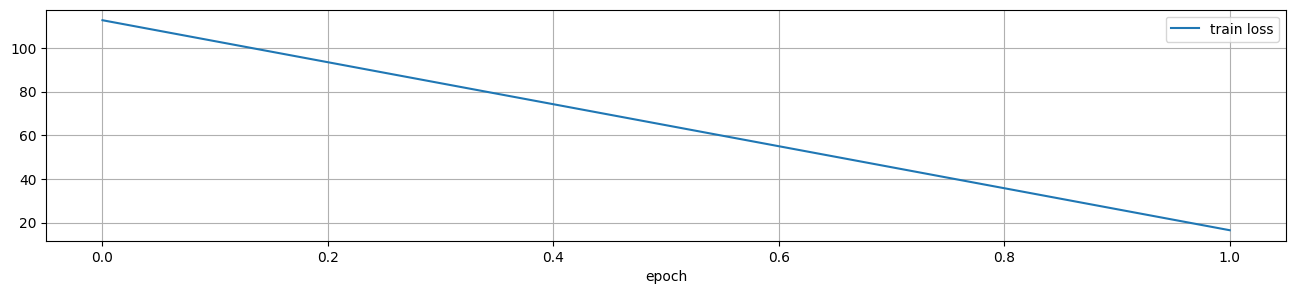

0.0014897455694153905 0.5777047276496887
-0.0003565885708667338 0.5784240365028381


In [ ]:
hidden_dim = 6272
start_mode = True
valid_mode = False
# TODO: Visualize conv layer output
samples = [
    # in_ch * h * w,
    1 * 3 * 3,
    2 * 3 * 3,
    2 * 3 * 3,
    # 4 * 8 * 3 * 3,
    hidden_dim,
]
sets = [
    # out_ch
    2,
    2,
    2,
    # 1,
    num_classes
]
n_params = int(np.array(samples).dot(np.array(sets)))

torch.cuda.empty_cache()

if start_mode:
  # model = MModule(
  model = MModule2(
      n_params=n_params,
      idx_dim=idx_dim,
      samples=samples,
      sets=sets,
      device=device,
      probe_dim=hidden_dim,
  )
  optimizer = Adam(model.parameters(), lr=1e-3) # 1e-2

train_log = {
    "train loss": [],
    "eval loss": [],
    "acc": [],
    "set": [],
    "epoch": [],
}

num_epochs = 720 * 4
epoch_len = 60

for epoch in range(num_epochs):
  ###
  print(model.W.mean().item(), model.W.std().item())
  print(model.W_idx.mean().item(), model.W_idx.std().item())
  ###
  model.train()
  train_iter = iter(train_data_loader)
  for _ in range(epoch_len):
    x, y = next(train_iter)
    x = x.to(device)
    y = y.to(device)
    x, y = prepare_input(x, y, device=device)
    y_pred = model.forward(x)
    optimizer.zero_grad()
    loss = maromba_loss(y, y_pred)
    loss.backward()
    optimizer.step()
    train_log["train loss"].append(loss.item())
    train_log["eval loss"].append(np.nan)
    train_log["acc"].append(np.nan)
    train_log["set"].append("train")
    train_log["epoch"].append(epoch)
  if valid_mode:
    model.eval()
    with torch.no_grad():
      for x, y in iter(test_data_loader):
        x = x.to(device)
        y = y.to(device)
        x, y = prepare_input(x, y, device=device)
        y_pred = model.forward(x)
        loss = maromba_loss(y, y_pred)
        acc = maromba_accuracy(y, y_pred)
        train_log["eval loss"].append(loss.item())
        train_log["train loss"].append(np.nan)
        train_log["acc"].append(acc.item())
        train_log["set"].append("eval")
        train_log["epoch"].append(epoch)
    group_cols = ["epoch", "train loss", "eval loss", "acc"]
  else:
    group_cols = ["epoch", "train loss"]
  df_train = pd.DataFrame(train_log)
  display.clear_output(wait=True)
  (
    df_train[group_cols]
    .groupby("epoch")
    .agg(lambda x: x.median(skipna=True))
    # .tail(200)
    .plot(figsize=(16, 3), grid=True)
  )
  plt.show()

In [ ]:
# tidx = aidx.reshape(32, -1, 9, 3)[0, 100].cpu().detach().numpy(); tidx = tidx.reshape(-1, 3)
# tidx = aidx.reshape(32, -1, 9, 2)[0].cpu().detach().numpy(); tidx = tidx.reshape(-1, 2)

# plot_df = pd.DataFrame({"x": tidx[:, 0], "y": tidx[:, 1], "z": tidx[:, 1] * 0.0})
# fig = px.scatter_3d(plot_df, x="x", y="y", z="z", color=None); fig.show();
# midx.reshape(32, -1, 3)[0, 100:105].cpu().detach().numpy()
torch.cuda.empty_cache()

In [ ]:
df_train

In [18]:
imgs = [img.data.cpu().detach() for img in model.all_pools]
idxs = [img.idx.cpu().detach() for img in model.all_pools]

In [19]:
[img.shape for img in imgs]

[torch.Size([4, 784])]

In [ ]:
shapes = [
    (img_dim, img_dim, 1),
    ((img_dim - 0) // 1, (img_dim - 0) // 1, 1),
    # ((img_dim - 0) // 1, (img_dim - 0) // 1, 8),
    # (((img_dim - 2) // 2 - 2) // 1, ((img_dim - 2) // 2 - 2) // 1, 4),
    # (((img_dim - 4) // 1 - 4) // 2, ((img_dim - 4) // 1 - 4) // 2, 8),
    # ((img_dim - 4) // 2 - 2, (img_dim - 4) // 2 - 2, 4),
    # ((img_dim - 4) // 2 - 4, (img_dim - 4) // 2 - 4, 8),
]
# display.clear_output(wait=True)
plt.close()
for idx, img in enumerate(imgs[:len(shapes)]):
  img = img[0]
  print(img.shape)
  img = img.reshape(*shapes[idx])
  rows, cols = 1, shapes[idx][2]
  fig, ax = plt.subplots(rows, cols, figsize=(min(18, 3 * cols), 3))
  for ch in range(cols):
    img_ = img[:, :, ch].numpy()
    if cols > 1:
      ax[ch].imshow(img_)
    else:
      ax.imshow(img_)
  plt.show()

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def scatter3d(x, y, z):
  plot_df = pd.DataFrame({"x": x, "y": y, "z": z})
  fig = px.scatter_3d(plot_df, x="x", y="y", z="z", color=None)
  return fig

# plt.clf(); plt.cla()
# plt.close()
for i, idx in enumerate(idxs[:len(shapes)]):
  idx = idx[0]
  print(idx.shape)
  idx = idx.reshape(-1, shapes[i][2], idx_dim)
  rows, cols = 1 + (idx.shape[1] - 1) // 2, 2
  # fig = plt.figure(figsize=(min(18, 3 * cols), 3))
  fig = make_subplots(
    rows=rows, cols=cols,
    specs=[[{"type": "scene"} for _ in range(cols)] for _ in range(rows)],
    # row_heights=[10 for _ in range(rows)],
    vertical_spacing=0.05
  )
  fig.update_layout(
    height=600 * rows,
    width=600 * cols
)
  for ch in range(idx.shape[1]):
    idx_ = idx[:, ch].numpy()
    # ax = fig.add_subplot(rows, cols, ch + 1, projection="3d")
    # ax.scatter(idx_[::4, 0], idx_[::4, 1], idx_[::4, 2], marker="+")
    # fig = scatter3d(idx_[::4, 0], idx_[::4, 1], idx_[::4, 2])
    row, col = (ch // cols) + 1, (ch % cols) + 1
    fig.add_trace(
        go.Scatter3d(
            x=idx_[::, 0],
            y=idx_[::, 1],
            z=idx_[::, 2],
            # color=None,
            # colorscale="Viridis",
            # showscale=False
        ),
        row=row,
        col=col,
    )
  fig.show()
  # plt.show()

torch.Size([784, 3])


torch.Size([784, 1, 3])


In [ ]:
# model.MW.idx[0, 0]
threshold = rows * cols * hidden_dim
param_id = 0
layer_idx = model.MW.idx[:, param_id: param_id + 100] # threshold
n_parts = idx_dim // img_dim
scaled_idx = (
    MTensor
    ._soft_kernel(layer_idx, img_dim)[0]
    .reshape(-1, n_parts, img_dim)
) * (n_parts ** 0.5)
idx_att = torch.argmax(
    scaled_idx,
    dim=-1
)[:, :2]
idx_att = idx_att.cpu().detach().numpy()
grid = np.zeros((rows, cols))
# for pos in range(len(idx_att)):
#   idxx, idxy = idx_att[pos]
#   idxx, idxy = int(idxx), int(idxy)
#   # grid[int(idxx), int(idxy)] += 1
#   grid[idxx, idxy] += scaled_idx[pos, 0, idxx] * scaled_idx[pos, 1, idxy]
for idxx in range(rows):
  for idxy in range(cols):
    grid[idxx, idxy] = (scaled_idx[:, 0, idxx] * scaled_idx[:, 1, idxy]).sum()
grid = grid / grid.max()

# plt.imshow(grid)

fig, ax = plt.subplots()
ax.matshow(grid, cmap="seismic")

for (i, j), z in np.ndenumerate(grid):
    ax.text(j, i, "{:0.2f}".format(z), ha="center", va="center")

plt.show()

In [ ]:
MTensor._soft_kernel(y_pred.idx, img_dim)[0]

### Visualização dos índices dos parâmetros

In [ ]:
soft_W_idx = scaled_idx # MTensor._soft_kernel(model.MW.idx, img_dim)
threshold = 100 # rows * cols * hidden_dim
# First layer
soft_W_idx = soft_W_idx[:, :threshold].reshape(1, -1, idx_dim)
# Last layer
# soft_W_idx = soft_W_idx[:, threshold:].reshape(1, -1, idx_dim)
soft_W_idx = soft_W_idx.cpu().detach().numpy()[0]

In [ ]:
from sklearn.manifold import TSNE

sample_idx = np.random.choice(
    len(soft_W_idx),
    min(len(soft_W_idx), 10000),
    replace=False
)

W_idx_tsne = TSNE(
    n_components=2,
    perplexity=10,
).fit_transform(soft_W_idx[sample_idx])

In [ ]:
plot_df = pd.DataFrame(
    {
        "W_idx x tsne": W_idx_tsne[:, 0],
        "W_idx y tsne": W_idx_tsne[:, 1],
    }
)

plot_df.plot.scatter(
    x="W_idx x tsne",
    y="W_idx y tsne",
    figsize=(24, 4),
    grid=True
)